# evaluation functions 

In [1]:
import matplotlib
matplotlib.use('Agg')
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score, cohen_kappa_score, jaccard_similarity_score, log_loss,recall_score, precision_score
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline


In [28]:
root = '/scratch/sb3923/deep-cancer/'
experiment = 'train_lung_ds3'
pred_label = 'pred_label_avg_train_lung_ds3_epoch_13.pth.npy'
num_class = 3 #input


In [29]:
#get the train log file

new_model=experiment
infile = root+"logs/"+experiment+".log"

auc_new = []
phrase = "Class encoding:"


with open(infile, 'r+') as f:
    lines = f.readlines()
    for i in range(0, len(lines)):
        line = lines[i]
        #print(line)
        if phrase in line:
            class_encoding = lines[i + 1] # you may want to check that i < len(lines)
            break
            



In [30]:
class_encoding = class_encoding.strip('\n').strip('{').strip('}')
class_names = []
class_codes = []

for c in class_encoding.split(','):
    class_names.append(c.split(':')[0].replace("'", "").replace(" ", ""))
    class_codes.append(int(c.split(':')[1]))
    
class_names = sorted(class_names)
class_codes = sorted(class_codes)


class_coding = {}
for i in range(len(class_names)):
    class_coding[class_codes[i]] = class_names[i]

print(class_coding)


{0: 'ST_Normal_Lung', 1: 'TCGA-LUAD', 2: 'TCGA-LUSC'}


In [31]:
os.chdir(root+'/experiments/'+experiment) #input

In [32]:
pred_label = np.load(open(pred_label, 'rb'))
#print(pred_label)
predictions = pred_label[:,:num_class]
labels = pred_label[:,num_class] 

#columns: 0 class, 1 class, 2 class, labels 


In [33]:
len(labels)

224

In [34]:
def get_tpf_fpr(predictions, labels, class_codes):
    """
    Given predictions and labels, return the AUCs for all classes
    and micro, macro AUCs. Also saves a plot of the ROC curve to the
    path.

    """

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    if len(classes) > 2:
        # Convert labels to one-hot-encoding
        labels = label_binarize(labels, classes = classes)

        ### Individual class AUC ###
        for i in classes:
            fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ### Micro AUC ###
        fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), predictions.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Macro AUC ###
        all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in classes:
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(classes)

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ### Make plot ###      
    else:
        fpr, tpr, _ = roc_curve(labels, predictions[:,1])
        auc_result = auc(fpr, tpr)

        for i in list(classes) + ['macro', 'micro']:
            roc_auc[i] = auc_result 

    return fpr, tpr, roc_auc

In [35]:
#confidence interval

def get_error(pred, true, classes=[0, 1, 2]):
    num_class=len(classes)

    n_bootstraps = 1000
    rng_seed0 = 42  # control reproducibility
    rng_seed1 = 100 # control reproducibility
    rng_seed2 = 250  # control reproducibility
    rng_seed3 = 400  # control reproducibility
    rng_seed4 = 650  # control reproducibility

    bootstrapped_scores0 = []
    bootstrapped_scores1 = []
    bootstrapped_scores2 = []
    bootstrapped_scores3 = []
    bootstrapped_scores4 = []
    
    rng0 = np.random.RandomState(rng_seed0)
    rng1 = np.random.RandomState(rng_seed1)
    rng2 = np.random.RandomState(rng_seed2)
    rng3 = np.random.RandomState(rng_seed3)
    rng4 = np.random.RandomState(rng_seed4)
    
    true_all=true.ravel()
    pred_all=pred.ravel()
   

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices0 = rng0.random_integers(0, len(pred[:,0]) - 1, len(pred[:,0]))
        if len(np.unique(true[indices0,0])) < 2:
            continue
        indices1 = rng1.random_integers(0, len(pred[:,1]) - 1, len(pred[:,1]))
        if len(np.unique(true[indices1,1])) < 2:
             continue
        if num_class>2:
            indices2 = rng2.random_integers(0, len(pred[:,2]) - 1, len(pred[:,2]))
            if len(np.unique(true[indices2,2])) < 2:
                continue
    
        if num_class>3:
            indices3 = rng3.random_integers(0, len(pred[:,3]) - 1, len(pred[:,3]))
            if len(np.unique(true[indices3,2])) < 2:
                continue

        indices4 = rng4.random_integers(0, len(pred_all) - 1, len(pred_all))
        if len(np.unique(true_all[indices4])) < 2:
            continue
       

        score0 = roc_auc_score(true[indices0,0], pred[indices0,0])
        score1 = roc_auc_score(true[indices1,1], pred[indices1,1])
        if num_class>2:
            score2 = roc_auc_score(true[indices2,2], pred[indices2,2])
        if num_class>3:
            score3 = roc_auc_score(true[indices3,3], pred[indices3,3])
        score4 = roc_auc_score(true_all[indices4], pred_all[indices4])

        bootstrapped_scores0.append(score0)
        bootstrapped_scores1.append(score1)
        if num_class>2:
            bootstrapped_scores2.append(score2)
        if num_class>3:
            bootstrapped_scores3.append(score3)
        bootstrapped_scores4.append(score4)

    sorted_scores0 = np.array(bootstrapped_scores0)
    sorted_scores0.sort()
    confidence_lower0 = sorted_scores0[int(0.05 * len(sorted_scores0))]
    confidence_upper0 = sorted_scores0[int(0.95 * len(sorted_scores0))]

    sorted_scores1 = np.array(bootstrapped_scores1)
    sorted_scores1.sort()
    confidence_lower1 = sorted_scores1[int(0.05 * len(sorted_scores1))]
    confidence_upper1 = sorted_scores1[int(0.95 * len(sorted_scores1))]

    if num_class>2:
        sorted_scores2 = np.array(bootstrapped_scores2)
        sorted_scores2.sort()
        confidence_lower2 = sorted_scores2[int(0.05 * len(sorted_scores2))]
        confidence_upper2 = sorted_scores2[int(0.95 * len(sorted_scores2))]

    if num_class>3:
        sorted_scores3 = np.array(bootstrapped_scores3)
        sorted_scores3.sort()
        confidence_lower3 = sorted_scores3[int(0.05 * len(sorted_scores3))]
        confidence_upper3 = sorted_scores3[int(0.95 * len(sorted_scores3))]
    
    #micro
    sorted_scores4=np.array(bootstrapped_scores4)                                      
    sorted_scores4.sort()
                                      
    confidence_lower_micro = sorted_scores4[int(0.05 * len(sorted_scores4))]
    confidence_upper_micro = sorted_scores4[int(0.95 * len(sorted_scores4))]                                    


    #macro
    
    if num_class==3:
        sorted_scores5=np.array(np.concatenate((bootstrapped_scores0,bootstrapped_scores1,bootstrapped_scores2), axis=0))

    if num_class==4:
        sorted_scores5=np.array(np.concatenate((bootstrapped_scores0,bootstrapped_scores1,bootstrapped_scores2,bootstrapped_scores3), axis=0))
    
    
    sorted_scores5.sort()
                                      
    confidence_lower_macro = sorted_scores5[int(0.05 * len(sorted_scores5))]
    confidence_upper_macro = sorted_scores5[int(0.95 * len(sorted_scores5))]                                    

    if num_class==3:
        all= [confidence_lower_macro, confidence_upper_macro,confidence_lower_micro, confidence_upper_micro, confidence_lower0,  confidence_upper0, confidence_lower1, confidence_upper1,confidence_lower2, confidence_upper2]
    if num_class==4:
        all= [confidence_lower_macro, confidence_upper_macro,confidence_lower_micro, confidence_upper_micro, confidence_lower0,  confidence_upper0,confidence_lower1, confidence_upper1,confidence_lower2, confidence_upper2,confidence_lower3, confidence_upper3]


    return all





def get_error_all(pred, true, classes=[0, 1, 2]):
    num_class=len(classes)

    n_bootstraps = 1000
    rng_seed0 = 42  # control reproducibility
    rng_seed1 = 100 # control reproducibility
    rng_seed2 = 250  # control reproducibility
    rng_seed3 = 400  # control reproducibility
    rng_seed4 = 650  # control reproducibility
    rng_seed5 = 876  # control reproducibility
    rng_seed6 = 256  # control reproducibility
    rng_seed7 = 93  # control reproducibility
    rng_seed8 = 8736  # control reproducibility
    rng_seed = 4537  # control reproducibility

    bootstrapped_scores0 = []
    bootstrapped_scores1 = []
    bootstrapped_scores2 = []
    bootstrapped_scores3 = []
    bootstrapped_scores4 = []
    bootstrapped_scores5 = []
    bootstrapped_scores6 = []
    bootstrapped_scores7 = []
    bootstrapped_scores8 = []
    bootstrapped_scores = []
    
    rng0 = np.random.RandomState(rng_seed0)
    rng1 = np.random.RandomState(rng_seed1)
    rng2 = np.random.RandomState(rng_seed2)
    rng3 = np.random.RandomState(rng_seed3)
    rng4 = np.random.RandomState(rng_seed4)
    rng5 = np.random.RandomState(rng_seed5)
    rng6 = np.random.RandomState(rng_seed6)
    rng7 = np.random.RandomState(rng_seed7)
    rng8 = np.random.RandomState(rng_seed8)
    rng = np.random.RandomState(rng_seed)
   
    true_all=true.ravel()
    pred_all=pred.ravel()
   

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices0 = rng0.random_integers(0, len(pred[:,0]) - 1, len(pred[:,0]))
        if len(np.unique(true[indices0,0])) < 2:
            continue
        indices1 = rng1.random_integers(0, len(pred[:,1]) - 1, len(pred[:,1]))
        if len(np.unique(true[indices1,1])) < 2:
             continue
        if num_class>2:
            indices2 = rng2.random_integers(0, len(pred[:,2]) - 1, len(pred[:,2]))
            if len(np.unique(true[indices2,2])) < 2:
                continue
    
        if num_class>3:
            indices3 = rng3.random_integers(0, len(pred[:,3]) - 1, len(pred[:,3]))
            if len(np.unique(true[indices3,2])) < 2:
                continue
                
        if num_class>8:
            indices4 = rng3.random_integers(0, len(pred[:,4]) - 1, len(pred[:,4]))
            indices5 = rng3.random_integers(0, len(pred[:,5]) - 1, len(pred[:,5]))
            indices6 = rng3.random_integers(0, len(pred[:,6]) - 1, len(pred[:,6]))
            indices7 = rng3.random_integers(0, len(pred[:,7]) - 1, len(pred[:,7]))
            indices8 = rng3.random_integers(0, len(pred[:,8]) - 1, len(pred[:,8]))
            if len(np.unique(true[indices4,2])) < 2:
                continue
            if len(np.unique(true[indices5,2])) < 2:
                continue
            if len(np.unique(true[indices6,2])) < 2:
                continue
            if len(np.unique(true[indices7,2])) < 2:
                continue
            if len(np.unique(true[indices8,2])) < 2:
                continue
                
                
                
        #for all classes 
        indices = rng.random_integers(0, len(pred_all) - 1, len(pred_all))
        if len(np.unique(true_all[indices])) < 2:
            continue
       

        score0 = roc_auc_score(true[indices0,0], pred[indices0,0])
        score1 = roc_auc_score(true[indices1,1], pred[indices1,1])
        if num_class>2:
            score2 = roc_auc_score(true[indices2,2], pred[indices2,2])
        if num_class>3:
            score3 = roc_auc_score(true[indices3,3], pred[indices3,3])
        if num_class>8:
            score4 = roc_auc_score(true[indices4,4], pred[indices4,4])  
            score5 = roc_auc_score(true[indices5,5], pred[indices5,5])
            score6 = roc_auc_score(true[indices6,6], pred[indices6,6])
            score7 = roc_auc_score(true[indices7,7], pred[indices7,7])
            score8 = roc_auc_score(true[indices8,8], pred[indices8,8])
        score = roc_auc_score(true_all[indices], pred_all[indices])

        
        
        bootstrapped_scores0.append(score0)
        bootstrapped_scores1.append(score1)
        if num_class>2:
            bootstrapped_scores2.append(score2)
        if num_class>3:
            bootstrapped_scores3.append(score3)
        if num_class>8:
            bootstrapped_scores4.append(score4)
            bootstrapped_scores5.append(score5)
            bootstrapped_scores6.append(score6)
            bootstrapped_scores7.append(score7)
            bootstrapped_scores8.append(score8)
        bootstrapped_scores.append(score)

    sorted_scores0 = np.array(bootstrapped_scores0)
    sorted_scores0.sort()
    confidence_lower0 = sorted_scores0[int(0.05 * len(sorted_scores0))]
    confidence_upper0 = sorted_scores0[int(0.95 * len(sorted_scores0))]

    sorted_scores1 = np.array(bootstrapped_scores1)
    sorted_scores1.sort()
    confidence_lower1 = sorted_scores1[int(0.05 * len(sorted_scores1))]
    confidence_upper1 = sorted_scores1[int(0.95 * len(sorted_scores1))]

    if num_class>2:
        sorted_scores2 = np.array(bootstrapped_scores2)
        sorted_scores2.sort()
        confidence_lower2 = sorted_scores2[int(0.05 * len(sorted_scores2))]
        confidence_upper2 = sorted_scores2[int(0.95 * len(sorted_scores2))]

    if num_class>3:
        sorted_scores3 = np.array(bootstrapped_scores3)
        sorted_scores3.sort()
        confidence_lower3 = sorted_scores3[int(0.05 * len(sorted_scores3))]
        confidence_upper3 = sorted_scores3[int(0.95 * len(sorted_scores3))]
        
    if num_class>8:
        sorted_scores4 = np.array(bootstrapped_scores4)
        sorted_scores4.sort()
        confidence_lower4 = sorted_scores4[int(0.05 * len(sorted_scores4))]
        confidence_upper4 = sorted_scores4[int(0.95 * len(sorted_scores4))]
        sorted_scores5 = np.array(bootstrapped_scores5)
        sorted_scores5.sort()
        confidence_lower5 = sorted_scores5[int(0.05 * len(sorted_scores5))]
        confidence_upper5 = sorted_scores5[int(0.95 * len(sorted_scores5))]
        sorted_scores6 = np.array(bootstrapped_scores6)
        sorted_scores6.sort()
        confidence_lower6 = sorted_scores6[int(0.05 * len(sorted_scores6))]
        confidence_upper6 = sorted_scores6[int(0.95 * len(sorted_scores6))]
        sorted_scores7 = np.array(bootstrapped_scores7)
        sorted_scores7.sort()
        confidence_lower7 = sorted_scores7[int(0.05 * len(sorted_scores7))]
        confidence_upper7 = sorted_scores7[int(0.95 * len(sorted_scores7))]
        sorted_scores8 = np.array(bootstrapped_scores8)
        sorted_scores8.sort()
        confidence_lower8 = sorted_scores8[int(0.05 * len(sorted_scores8))]
        confidence_upper8 = sorted_scores8[int(0.95 * len(sorted_scores8))]
        
    #micro
    sorted_scores_micro=np.array(bootstrapped_scores)                                      
    sorted_scores_micro.sort()
                                      
    confidence_lower_micro = sorted_scores_micro[int(0.05 * len(sorted_scores_micro))]
    confidence_upper_micro = sorted_scores_micro[int(0.95 * len(sorted_scores_micro))]                                    


    #macro
    if num_class==3:
        sorted_scores_macro=np.array(np.concatenate((bootstrapped_scores0,bootstrapped_scores1,bootstrapped_scores2), axis=0))

    if num_class==4:
        sorted_scores_macro=np.array(np.concatenate((bootstrapped_scores0,bootstrapped_scores1,bootstrapped_scores2,bootstrapped_scores3), axis=0))
    
    if num_class==9:
        sorted_scores_macro=np.array(np.concatenate((bootstrapped_scores0,bootstrapped_scores1,bootstrapped_scores2,bootstrapped_scores3,bootstrapped_scores4,bootstrapped_scores5,bootstrapped_scores6,bootstrapped_scores7,bootstrapped_scores8), axis=0))
    
    
    sorted_scores_macro.sort()
                                      
    confidence_lower_macro = sorted_scores_macro[int(0.05 * len(sorted_scores_macro))]
    confidence_upper_macro = sorted_scores_macro[int(0.95 * len(sorted_scores_macro))]                                    

    if num_class==3:
        all= [confidence_lower_macro, confidence_upper_macro,confidence_lower_micro, confidence_upper_micro, confidence_lower0,  confidence_upper0, confidence_lower1, confidence_upper1,confidence_lower2, confidence_upper2]
    if num_class==4:
        all= [confidence_lower_macro, confidence_upper_macro,confidence_lower_micro, confidence_upper_micro, confidence_lower0,  confidence_upper0,confidence_lower1, confidence_upper1,confidence_lower2, confidence_upper2,confidence_lower3, confidence_upper3]
    if num_class==9:
        all= [confidence_lower_macro, confidence_upper_macro,confidence_lower_micro, confidence_upper_micro, confidence_lower0,  confidence_upper0,confidence_lower1, confidence_upper1,confidence_lower2, confidence_upper2,confidence_lower3, confidence_upper3,confidence_lower4, confidence_upper4,confidence_lower5, confidence_upper5,confidence_lower6, confidence_upper6,confidence_lower7, confidence_upper7,confidence_lower8, confidence_upper8]


    return all


In [36]:
def get_auc(predictions, labels, class_names, classes=[0, 1, 2]):

    """
    Given predictions and labels, return the AUCs for all classes
    and micro, macro AUCs. Also saves a plot of the ROC curve to the
    path.
    """

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    label=labels 

    if len(classes) > 2:
        # Convert labels to one-hot-encoding
        labels = label_binarize(labels, classes = classes)

        ### Individual class AUC ###
        for i in classes:
            fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        errors=get_error_all(predictions,labels,classes)

        ### Micro AUC ###
        fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), predictions.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        roc_auc["micro_cl"]=errors[2]
        roc_auc["micro_cu"]=errors[3]


        ### Macro AUC ###
        all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in classes:
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(classes)

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]) 
        roc_auc["macro_cl"]=errors[0]      
        roc_auc["macro_cu"]=errors[1]
 
        if len(classes)==3:
            roc_auc["cu0"]=errors[5]
            roc_auc["cu1"]=errors[7]
            roc_auc["cu2"]=errors[9] 
            roc_auc["cl0"]=errors[4]
            roc_auc["cl1"]=errors[6]
            roc_auc["cl2"]=errors[8]
        if len(classes)==4:
            roc_auc["cu0"]=errors[5]
            roc_auc["cu1"]=errors[7]
            roc_auc["cu2"]=errors[9]
            roc_auc["cu3"]=errors[11]
 
            roc_auc["cl0"]=errors[4]
            roc_auc["cl1"]=errors[6]
            roc_auc["cl2"]=errors[8]
            roc_auc["cl3"]=errors[10]
        if len(classes)==9:
            roc_auc["cu0"]=errors[5]
            roc_auc["cu1"]=errors[7]
            roc_auc["cu2"]=errors[9]
            roc_auc["cu3"]=errors[11]
            roc_auc["cu4"]=errors[13]
            roc_auc["cu5"]=errors[15]
            roc_auc["cu6"]=errors[17]
            roc_auc["cu7"]=errors[19]
            roc_auc["cu8"]=errors[21]
 
            roc_auc["cl0"]=errors[4]
            roc_auc["cl1"]=errors[6]
            roc_auc["cl2"]=errors[8]
            roc_auc["cl3"]=errors[10]
            roc_auc["cl4"]=errors[12]
            roc_auc["cl5"]=errors[14]
            roc_auc["cl6"]=errors[16]
            roc_auc["cl7"]=errors[18]
            roc_auc["cl8"]=errors[20]
        
        #new metrics
        precision = precision_score(label, np.argmax(predictions,axis=1),average='macro')
        recall = recall_score(label, np.argmax(predictions,axis=1), average='macro')
        cohenskappa = cohen_kappa_score(label, np.argmax(predictions,axis=1))
        jaccard = jaccard_similarity_score(label, np.argmax(predictions,axis=1))
        logloss = log_loss(label, predictions, labels=classes)
         
        roc_auc['precision']=precision
        roc_auc['recall']=recall
        roc_auc['cohenskappa']=cohenskappa
        roc_auc['jaccard']=jaccard
        roc_auc['logloss']=logloss

        ### Make plot ###
        plt.figure(figsize=(12, 12))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average: AUC = {0:0.3f}'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average: AUC = {0:0.3f}'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue','forestgreen','sienna','darkslateblue','limegreen','cadetblue','firebrick'])
        for i, color in zip(classes, colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='{0}: AUC = {1:0.3f}'
                     ''.format(class_names[i], roc_auc[i]))

    else:

        fpr, tpr, _ = roc_curve(labels, predictions[:,1])
        auc_result = auc(fpr, tpr)
        
        for i in list(classes) + ['macro', 'micro']:
            roc_auc[i] = auc_result

        num_class=2
        #Confidence interval calculation 
        n_bootstraps = 1000
        rng_seed = 76494  # control reproducibility
        bootstrapped_scores = []
        rng = np.random.RandomState(rng_seed)
       
        for i in range(n_bootstraps):
          # bootstrap by sampling with replacement on the prediction indices
            indices = rng.random_integers(0, len(predictions[:,1]) - 1, len(predictions[:,1]))

            if len(np.unique(labels[indices])) < 2:
                continue
            score = roc_auc_score(labels[indices], predictions[indices,1])
            bootstrapped_scores.append(score)

        sorted_scores = np.array(bootstrapped_scores)
        confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]

        roc_auc["cu"]=confidence_upper
        roc_auc["cl"]=confidence_lower

        #new metrics
        precision = precision_score(label, np.argmax(predictions,axis=1),average='macro')
        recall = recall_score(label, np.argmax(predictions,axis=1), average='macro')
        cohenskappa = cohen_kappa_score(label, np.argmax(predictions,axis=1))
        jaccard = jaccard_similarity_score(label, np.argmax(predictions,axis=1))
        logloss = log_loss(label, predictions,labels=classes)

        roc_auc['precision']=precision
        roc_auc['recall']=recall
        roc_auc['cohenskappa']=cohenskappa
        roc_auc['jaccard']=jaccard
        roc_auc['logloss']=logloss

        plt.figure(figsize=(12, 12))
        plt.plot(fpr, tpr, lw=2,
                 label='TCGA-BRCA: AUC = {0:0.3f}'
                 ''.format(auc_result))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=34)
    plt.ylabel('True Positive Rate', fontsize=34)
    plt.title('ROC Curve', fontsize=32)
    plt.legend(loc="lower right", fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    print(class_encoding)
    print(roc_auc)
    return 

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:167: DeprecationWarning: This function is deprecated. Please call randint(0, 223 + 1) instead
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:170: DeprecationWarning: This function is deprecated. Please call randint(0, 223 + 1) instead
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:174: DeprecationWarning: This function is deprecated. Please call randint(0, 223 + 1) instead
/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:203: DeprecationWarning: This function is deprecated. Please call randint(0, 671 + 1) instead


'TCGA-LUSC': 2, 'ST_Normal_Lung': 0, 'TCGA-LUAD': 1
{0: 0.99664793453613321, 1: 0.94129710330684435, 2: 0.93317527221636809, 'cl0': 0.99189862899875358, 'cu0': 0.99990324141267539, 'cl1': 0.91432291666666665, 'macro_cu': 0.9989942673237453, 'micro_cu': 0.9632623368225357, 'logloss': 0.43617982651799203, 'recall': 0.82850572007198509, 'precision': 0.84111373466484707, 'jaccard': 0.8125, 'cu2': 0.95890410958904104, 'micro_cl': 0.93716326714891995, 'cl2': 0.90689801100296241, 'macro_cl': 0.91326004809343864, 'cu1': 0.96391263057929721, 'macro': 0.9591088677088736, 'micro': 0.95081313775510201, 'cohenskappa': 0.71869393613204158}


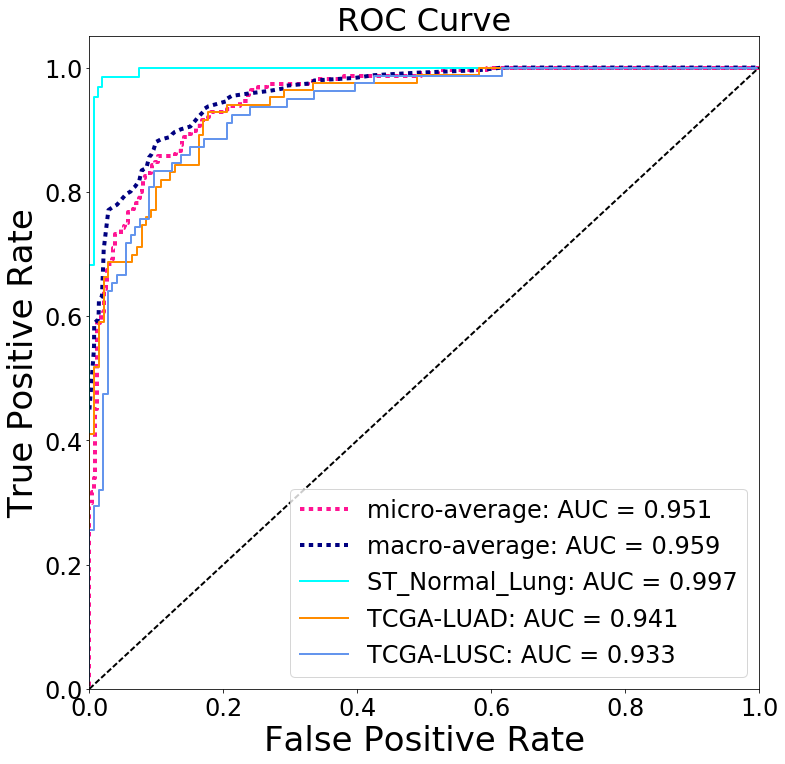

In [37]:
roc = get_auc(predictions, labels, class_names, class_codes)